# Modelling Nuclear Scattering
We investigate the Rutherford scattering formula and the findings of the Geiger-Marsden experiments.

## Single Atom Scattering
Models an incident alpha particle interacting with a single metal atom.

#### Initial Setup

In [1]:
#dependencies
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from functools import partial
from ase.lattice.cubic import FaceCenteredCubic
from collections import Counter
import random
#numba significantly speeds up computations by compiling function beforehand
from numba import jit
from multiprocessing import Pool
#stop runtime warnings
import warnings
warnings.filterwarnings('ignore')

#constants
charge_of_alpha = 2 * constants.e
mass_of_alpha = constants.physical_constants["alpha particle mass"][0]
coulomb_constant = 1 / (4 * math.pi * constants.epsilon_0)

#class for access to properties of an element
class Element():
    def __init__(self, symbol, atomic_number, atomic_mass):
        self.symbol = symbol
        self.atomic_number = atomic_number
        self.charge = atomic_number * constants.e
        self.mass = atomic_mass * constants.physical_constants["unified atomic mass unit"][0]

#elements
gold = Element("Au", 79, 196.96657)
tin = Element("Sn", 50, 118.71)
silver = Element("Ag", 47, 107.8682)
copper = Element("Cu", 29, 63.546)
aluminium = Element("Al", 13, 26.981539)
all_elements = [gold, tin, silver, copper, aluminium]


def MeV_to_joules(MeV):
    return MeV * 1e6 * constants.e

def energy_to_velocity(MeV):
    energy_in_joules = MeV_to_joules(MeV)
    return math.sqrt(energy_in_joules * 2 / mass_of_alpha)

#simulation parameters
average_energy_of_alpha = 5.0 #average kinetic energy of alpha particle in MeV
v0 = energy_to_velocity(average_energy_of_alpha)  #starting velocity in x-axis
sd = 1e-8   #simulation domain: radius of measurement sphere from the origin
dt = 5e-22  #timestep
starting_x = 5e-9 #distance from the closest atom in x-axis to start simulation
atom_positions = np.array([[0.0,0.0,0.0]]) #single atom at origin

@jit(nopython=True, fastmath=True)
def coulomb_force(alpha_position, atom_positions, element_charge):
    #params: position vector [x,y,z] of alpha particle, 2D array of the positions of the scattering atoms, charge of scattering atom
    #returns: 2D array of forces [[Fx, Fy, Fz], ...] on the alpha particle from each atom

    #vectors from atom positions to alpha particle position
    r_to_alpha = alpha_position - atom_positions 
    #|r| ^ 2
    sum_distances_squared = (r_to_alpha ** 2).sum(axis = 1)
    #1 / (|r| ^ 3)
    inv_r3 = sum_distances_squared ** (-1.5)
    #coulomb force calculation: each row in r_to_alpha matrix multiplied by corresponding scalar in inv_r3
    force = (r_to_alpha.T * inv_r3).T * (coulomb_constant * element_charge * charge_of_alpha)
    return force

@jit(nopython=True, fastmath=True)
def scattering_angle(initial_v, final_v):
    #returns the angle (in radians) between two vectors
    costheta = np.dot(final_v, initial_v)  / (np.linalg.norm(final_v) * np.linalg.norm(initial_v))
    theta = math.acos(costheta)
    return theta

def expected_scattering_angle(b, v0, element):
    #returns analytical solution to scattering angle (in radians) given impact parameter
    if b == 0.0: return math.pi #avoid division by zero
    return 2 * math.atan((coulomb_constant * charge_of_alpha * element.charge) / (mass_of_alpha * (v0 ** 2) * b))

def percentage_error(expected_value, actual_value):
    return ((actual_value - expected_value) / expected_value) * 100

#### Euler-Cromer Method

In [2]:
@jit(nopython=True, fastmath=True)
def euler_cromer(b, v0, element_charge, atom_positions):
    #returns trajectory and scattering angle given impact parameter (applied in z-axis), charge of scattering material, atom positions using euler-cromer method
    trajectory = []                                #appends position (x,y,z) at every timestep  
    position = np.array([-starting_x, 0.0, b])     #current particle position
    initial_v = np.array([v0, 0.0, 0.0])           #store initial particle velocity for final angle calculation
    velocity = initial_v.copy()                    #current particle velocity
    #until it goes beyond simulation domain
    while np.linalg.norm(position) <= sd:
        trajectory.append(position.copy())
        acc = coulomb_force(position, atom_positions, element_charge).sum(axis = 0) / mass_of_alpha  #find acceleration on a-particle
        velocity += dt * acc        #update velocity
        position += dt * velocity   #update position
    theta = scattering_angle(initial_v, velocity) #scattering angle between final and initial velocity vectors
    return (trajectory, theta)

In [3]:
def plot_trajectories_wrapper(func):
    #wrapper helper function to avoid repetitive code for plotting trajectories
    def wrap(*args, **kwargs):
        #setting up plot
        ax = plt.subplot(1,1,1)
        plt.xlabel("x axis")
        plt.ylabel("z axis")
        plt.title(kwargs["title"], pad=15)
        ax.set_xlim((-3e-13, 3e-13))
        ax.set_ylim((-3e-13, 7e-13))
        kwargs["ax"] = ax
        #call function to plot
        func(*args, **kwargs)
        #plot legend on the side
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
        ax.legend(loc="center left", bbox_to_anchor=(1,0.5))
        plt.show()
    return wrap

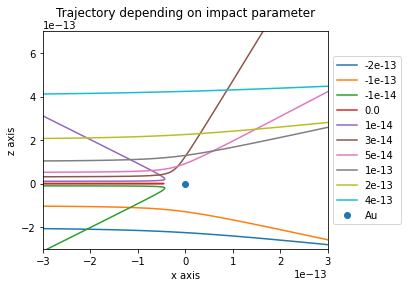

In [4]:
@plot_trajectories_wrapper
def dependence_on_impact_params(element, v0, bs, title, ax=None):
    ax.scatter(0,0,label=element.symbol) #plot atom
    for b in bs: 
        trajectory = np.array(euler_cromer(b, v0 = v0, element_charge=element.charge, atom_positions=np.array([[0.0,0.0,0.0]]))[0])
        #plot x and z axis
        ax.plot(trajectory[:,0],trajectory[:,2], label = b)
bs_to_plot = [-2e-13, -1e-13,-1e-14, 0.0, 1e-14, 3e-14, 5e-14, 1e-13, 2e-13, 4e-13]
dependence_on_impact_params(element=gold, v0=v0, bs=bs_to_plot,title="Trajectory depending on impact parameter")
    

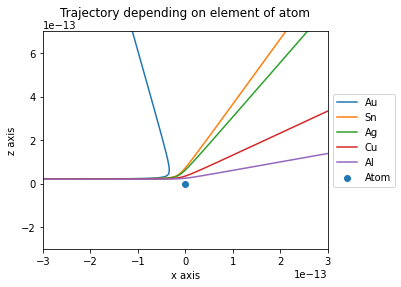

In [5]:
@plot_trajectories_wrapper
def dependence_on_element(elements, v0, b, title, ax=None):
    ax.scatter(0,0,label="Atom")
    for element in elements:
        trajectory = np.array(euler_cromer(b, v0 = v0, element_charge=element.charge, atom_positions=atom_positions)[0])
        #plot x and z axis
        ax.plot(trajectory[:,0],trajectory[:,2], label = element.symbol)
dependence_on_element(elements=all_elements, v0=v0, b=2e-14, title="Trajectory depending on element of atom")


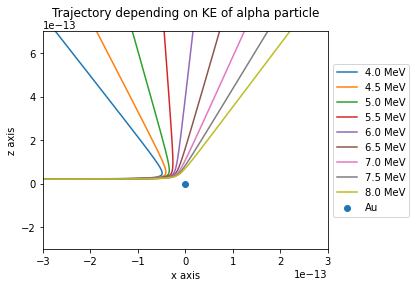

In [6]:
@plot_trajectories_wrapper
def dependence_on_ke(element, energies, b, title, ax=None):
    ax.scatter(0,0,label=element.symbol)
    for ke in energies:
        v0 = energy_to_velocity(ke)
        trajectory = np.array(euler_cromer(b, v0 = v0, element_charge=element.charge, atom_positions=atom_positions)[0])
        #plot x and z axis
        ax.plot(trajectory[:,0],trajectory[:,2], label = f"{ke} MeV")
energies = np.arange(4.0, 8.5, 0.5) #list of energies in MeV to plot from 4.0 - 8.0
dependence_on_ke(element=gold, energies=energies, b=2e-14, title="Trajectory depending on KE of alpha particle")


#### Runga-Kutta Methods

In [7]:
@jit(nopython=True, fastmath=True, cache=True)
def reached_boundary(t, S):
    #terminates solve_ivp when alpha particle reaches simulation boundary which causes a sign-change in the function
    position, _ = np.array_split(S, 2)
    return sd - np.linalg.norm(position)
reached_boundary.terminal = True

@jit(nopython=True, fastmath=True, cache=True)
def rhs(t, S, element_charge, atom_positions):
    alpha_position, velocity = np.array_split(S, 2)
    force = coulomb_force(alpha_position, atom_positions, element_charge)
    acceleration = force.sum(axis = 0) / mass_of_alpha
    return np.hstack((velocity, acceleration))

@jit(nopython=True, fastmath=True, cache=True)
def rhs_3rd_law(t, S, element_charge, element_mass):
    #uses newton 3rd law
    alpha_position, alpha_velocity, atoms = np.split(S, [3,6]) #splits array into 3 chunks, the last one representing information about the atoms
    atom_positions, atom_velocities=  np.split(np.reshape(atoms.copy(), (-1,3)), 2) #reshape atoms information into 2D and split into 2 chunks
    force = coulomb_force(alpha_position, atom_positions, element_charge)
    alpha_acceleration = force.sum(axis = 0) / mass_of_alpha #sum of all forces on a-particle
    atom_accelerations = -(force) / element_mass
    return np.hstack((alpha_velocity, alpha_acceleration, atom_velocities.ravel(), atom_accelerations.ravel()))


def runge_kutta(initial_pos, v0, element, atom_positions, method, third_law = False, rtol=1e-7, atol=1e-7):
    #returns scattering angle given params
    initial_v = np.array([v0, 0.0, 0.0])
    #cut-off time if it does not reach simulation boundary
    time_interval = sd * 2 / v0
    
    if third_law:
        initial_atom_positions = atom_positions.ravel()
        initial_atom_velocities = np.zeros(3 * len(atom_positions))
        initial_S = np.hstack((initial_pos, initial_v, initial_atom_positions, initial_atom_velocities))
        # print(initial_S)
        sol = solve_ivp(fun = lambda t,S: rhs_3rd_law(t, S, element.charge, element.mass), t_span = (0, time_interval), y0 = initial_S, events = reached_boundary, method = method, first_step = dt, rtol= rtol, atol=atol)
    else:
        initial_S = np.hstack((initial_pos, initial_v))
        sol = solve_ivp(fun = lambda t,S: rhs(t, S, element.charge, atom_positions), t_span = (0, time_interval), y0 = initial_S, events = reached_boundary, method = method, first_step = dt, rtol= rtol, atol=atol)

    if not sol.success:
        raise Exception("ODE solver failed to integrate")
    #number of time steps taken
    num_points = len(sol.t)
    #values of solution at each time step
    values = sol.y
    #retrieve final velocity
    final_v = values[:,num_points-1][3:6]
    theta = scattering_angle(initial_v, final_v)
    return theta

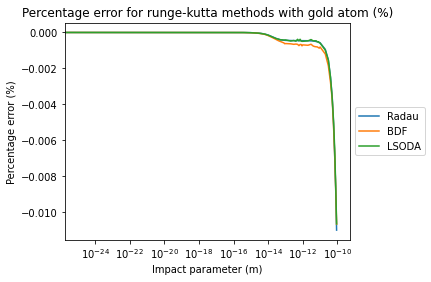

In [8]:
runge_kutta_methods = ["Radau", "BDF", "LSODA"]
# array of functions to call, partial makes it easier to iterate and call each function passing only the impact parameter 
methods = [partial(runge_kutta, method = runge_kutta_method, v0 = v0, element = gold, atom_positions = atom_positions) for runge_kutta_method in runge_kutta_methods]
#array of impact parameters to test from 0 to 9e-10
bs = [0.0] + [coeff * 10 ** p for p in range(-25,-10) for coeff in range(1,10)]
#set up plot
ax = plt.subplot(1,1,1)
plt.xlabel("Impact parameter (m)")
plt.ylabel("Percentage error (%)")
plt.title("Percentage error for runge-kutta methods with gold atom (%)")
ax.set_xscale("log")
for method in methods:
    #stores percentage error for each impact parameter point
    p_errors = []
    for b in bs:
        starting_position = np.array([-starting_x, 0.0, b])
        correct = math.degrees(expected_scattering_angle(b, v0, gold))
        theta = math.degrees(method(starting_position))
        p_error = percentage_error(correct, theta)
        p_errors.append(p_error)
    #get the name of the function
    function_name = method.keywords["method"] if type(method) == partial else method.__name__
    ax.plot(bs, p_errors,label=function_name)
#plot legend in nice format
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1,0.5))
plt.show()

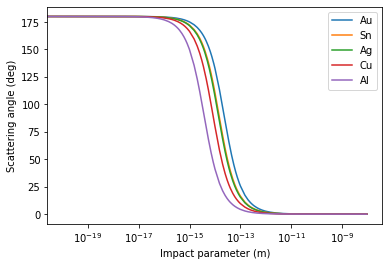

In [9]:
plt.xlabel("Impact parameter (m)")
plt.ylabel("Scattering angle (deg)")
bs = [0.0] + [coeff * 10 ** p for p in range(-20,-8) for coeff in np.arange(1,10,0.5)]
third_law_method = partial(runge_kutta, method = "LSODA", v0 = v0, atom_positions = atom_positions, third_law=True)
for element in all_elements:
    thetas = np.degrees([third_law_method(initial_pos=np.array([-starting_x, 0.0, b]), element=element) for b in bs])
    plt.plot(bs, thetas, label=element.symbol)
plt.legend()
plt.xscale("log")
plt.show()

Angle of most deviation for Au is: 103.30081927902108
Angle of most deviation for Sn is: 102.77611927365619
Angle of most deviation for Ag is: 104.39650820990667
Angle of most deviation for Cu is: 103.36493828085632
Angle of most deviation for Al is: 103.52754474834948


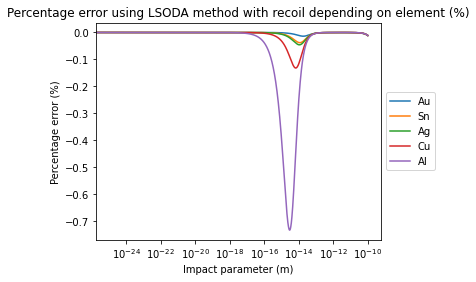

In [10]:
ax = plt.subplot(1,1,1)
plt.xlabel("Impact parameter (m)")
plt.ylabel("Percentage error (%)")
plt.title("Percentage error using LSODA method with recoil depending on element (%)")
ax.set_xscale("log")
bs = [0.0] + [coeff * 10 ** p for p in range(-25,-10) for coeff in np.arange(1,10,0.05)]
for element in all_elements:
    p_errors = []
    for b in bs:
        correct = math.degrees(expected_scattering_angle(b, v0, element))
        theta = math.degrees(third_law_method(initial_pos=np.array([-starting_x, 0.0, b]), element=element))
        p_error = percentage_error(correct, theta)
        p_errors.append(p_error)
    #find index of where there is most deviation
    idx = p_errors.index(min(p_errors))
    #show angle at which there is most deviation
    print(f"Angle of most deviation for {element.symbol} is: {math.degrees(expected_scattering_angle(bs[idx], v0, element))}")
    ax.plot(bs, p_errors,label=element.symbol)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1,0.5))
plt.show()

In [11]:
#b(theta)
b = lambda theta: ((coulomb_constant * charge_of_alpha * gold.charge) / (mass_of_alpha * 2e7 ** 2)) * (1 / math.atan(theta / 2))
print(b(math.radians(0.005)))

3.1431805172095485e-10


### Differential Cross Section

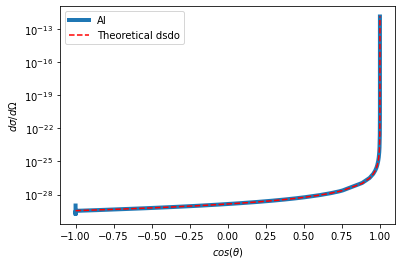

In [8]:
bs = [coeff * 10 ** p for p in range(-25,-10) for coeff in np.arange(1,10,0.5)]

#rutherford formula
calculate_theoretical_dsdo = lambda thetas, element, v0:((charge_of_alpha * element.charge) / (8 * math.pi * constants.epsilon_0 * mass_of_alpha * v0 ** 2 * np.sin(thetas/2.0) ** 2)) ** 2
#expression for scattering cross-section
calculate_dsdo = lambda bs, thetas: (bs / np.sin(thetas)) * np.abs(np.gradient(bs, thetas))

thetas = np.array([runge_kutta(initial_pos=np.array([-starting_x, 0.0, b]),v0=v0,element=aluminium,third_law=True,atom_positions=atom_positions, method = "LSODA") for b in bs])
costhetas = np.cos(thetas)
#calculate the differential cross section for both experimental and theoretical
dsdo = calculate_dsdo(bs, thetas)
theoretical_dsdo = calculate_theoretical_dsdo(thetas, aluminium, v0)
#plot against costheta
plt.plot(costhetas, dsdo,label=aluminium.symbol, linewidth=4.0)
plt.plot(costhetas, theoretical_dsdo, "r--", label="Theoretical dsdo")

plt.xlabel(r"$cos(\theta)$")
plt.ylabel(r"$d\sigma/d\Omega$")
plt.yscale("log")
plt.legend()
plt.show()

Plot $\log(\csc(\frac{\theta}{2}))$ against $\log(\frac{d\sigma}{d\Omega})$ to validate Rutherford proportionality relationship

Expected gradient is 4

In [25]:
#fitting functions
def straight_line_fit(thetas, m, c):
    return m * thetas + c

def cosec_half_4_fit(thetas, a):
    #csc(theta/2)**4
    return a / (np.sin(np.radians(thetas) / 2)**4)

def cosec_half_1_fit(thetas, a):
    #csc(theta/2)
    return a / (np.sin(np.radians(thetas) / 2))

def log_dsdo_log_cosec(bs, thetas, algorithm=""):
    #check whether differential cross section is really proportional to csc(theta/2)^4
    dsdo = calculate_dsdo(bs, thetas)
    log_dsdo = np.log(dsdo)
    log_cosec = np.log(cosec_half_1_fit(thetas, 1))
    m, c = curve_fit(straight_line_fit, log_cosec, log_dsdo)[0]
    print(f"Slope using {algorithm} is {m}, deviation is {abs(percentage_error(4.0, m))}%")
    plt.plot(log_cosec, log_dsdo, label="Data",linewidth=3)
    plt.plot(log_cosec, straight_line_fit(log_cosec, 4, c), "r--", label="Line with gradient of 4")
    plt.ylabel(r"$log(d\sigma/d\Omega)$")
    plt.xlabel(r"$log(csc(\theta/2))$")
    plt.legend()

Slope using Rutherford formula is 3.9965741791590763, deviation is 0.0856455210230922%


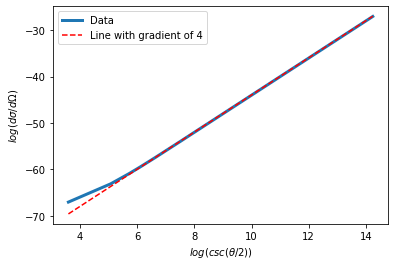

In [26]:
testing_element = aluminium
bs = np.linspace(1e-20, 1e-10, 10000)
thetas = np.array([expected_scattering_angle(b,v0,testing_element) for b in bs])
log_dsdo_log_cosec(bs, thetas, "Rutherford formula")

Slope using LSODA without Newton 3rd law is 3.996479869394182, deviation is 0.0880032651454532%


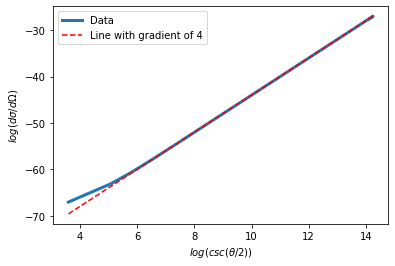

In [27]:
thetas = np.array([runge_kutta(initial_pos=np.array([-starting_x, 0.0, b]),v0=v0,element=testing_element,third_law=False,atom_positions=atom_positions, method = "LSODA") for b in bs])
log_dsdo_log_cosec(bs, thetas, "LSODA without Newton 3rd law")

Slope using LSODA with Newton 3rd law is 3.996501422904675, deviation is 0.08746442738312155%


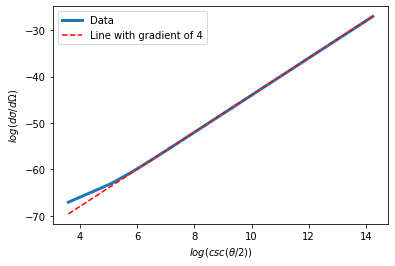

In [28]:
thetas = np.array([runge_kutta(initial_pos=np.array([-starting_x, 0.0, b]),v0=v0,element=testing_element,third_law=True,atom_positions=atom_positions, method = "LSODA") for b in bs])
log_dsdo_log_cosec(bs, thetas, "LSODA with Newton 3rd law")

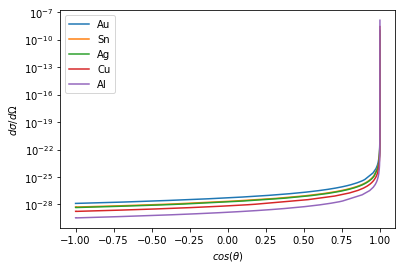

In [16]:
bs = [coeff * 10 ** p for p in range(-20,-9) for coeff in np.arange(1,10,0.5)]
for element in all_elements:
    thetas = np.array([third_law_method(initial_pos=np.array([-starting_x, 0.0, b]),element=element) for b in bs])
    costhetas = np.cos(thetas)
    #calculate the differential cross section
    dsdo = calculate_dsdo(bs, thetas)
    #plot against costheta
    plt.plot(costhetas, dsdo,label=element.symbol)

plt.xlabel(r"$cos(\theta)$")
plt.ylabel(r"$d\sigma/d\Omega$")
plt.yscale("log")
plt.legend()
plt.show()

#### Variation with different target nuclei
$\frac{d\sigma}{d\Omega} \propto  Q^2$

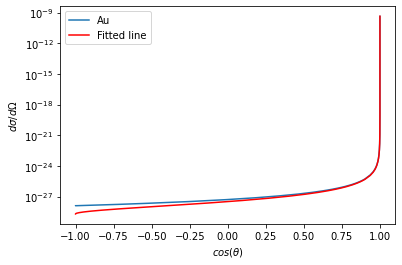

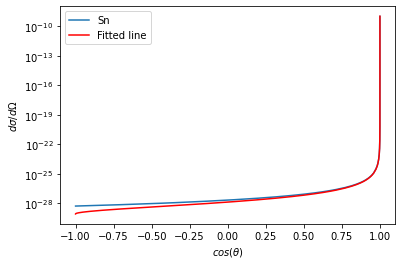

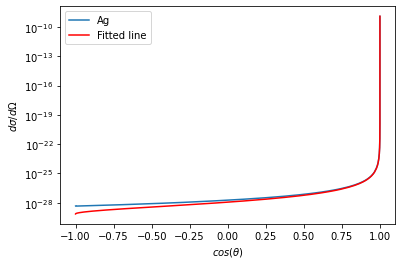

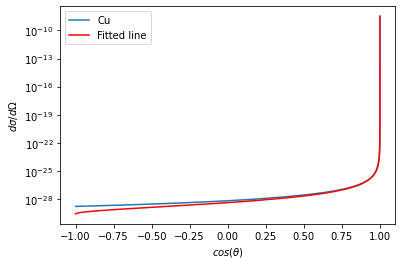

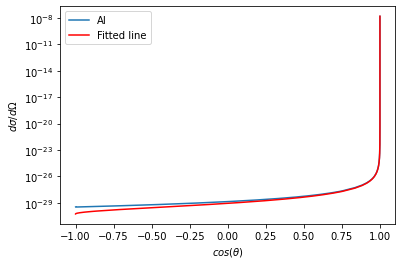

In [17]:
bs = [coeff * 10 ** p for p in range(-20,-9) for coeff in np.arange(1,10,0.25)]

coeffs = [] #array of k where line k * csc(theta/2)^4 fits data for each element 

for element in all_elements:
    thetas = np.array([third_law_method(initial_pos=np.array([-starting_x, 0.0, b]),element=element) for b in bs])
    costhetas = np.cos(thetas)
    dsdo = calculate_dsdo(bs, thetas)
    plt.plot(costhetas, dsdo, label=element.symbol)
    #fit data
    k = curve_fit(cosec_half_4_fit, thetas, dsdo)[0][0]
    coeffs.append(k)
    plt.plot(costhetas, cosec_half_4_fit(thetas, k), color="red", label="Fitted line")
    plt.yscale("log")
    plt.xlabel(r"$cos(\theta)$")
    plt.ylabel(r"$d\sigma/d\Omega$")
    plt.legend()
    plt.show()

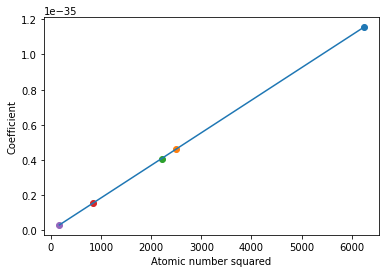

In [18]:
xs = [] #stores atomic number squared
for element, k in zip(all_elements, coeffs):
    atomic_number_squared = element.atomic_number ** 2
    xs.append(atomic_number_squared)
    plt.scatter(atomic_number_squared, k)
popt = curve_fit(straight_line_fit,xs, coeffs)[0]
plt.plot(xs, straight_line_fit(np.array(xs), *popt))
plt.ylabel("Coefficient")
plt.xlabel("Atomic number squared")
plt.show()

#### Variation with kinetic energy of alpha particles
$\frac{d\sigma}{d\Omega} \propto  \frac{1}{v^4}$

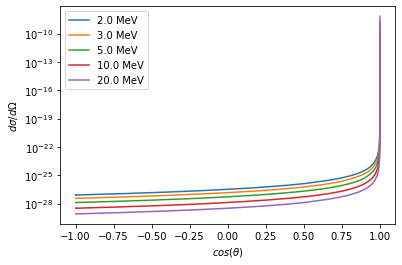

In [19]:
bs = [coeff * 10 ** p for p in range(-20,-9) for coeff in np.arange(1,10,0.25)]
coeffs = [] #array of k where line k * csc(theta/2)^4 fits data for each element 
energies = [2.0, 3.0, 5.0, 10.0, 20.0] #in MeV
velocities = list(map(energy_to_velocity, energies))
testing_element = gold
for energy, velocity in zip(energies,velocities):
    thetas = np.array([runge_kutta(initial_pos=np.array([-starting_x, 0.0, b]),v0=velocity,element=testing_element,third_law=True,atom_positions=atom_positions, method = "LSODA") for b in bs])
    costhetas = np.cos(thetas)
    dsdo = calculate_dsdo(bs, thetas)
    plt.plot(costhetas, dsdo, label=f"{energy} MeV")
    #fit data
    k = curve_fit(cosec_half_4_fit, thetas, dsdo)[0][0]
    coeffs.append(k)
plt.yscale("log")
plt.xlabel(r"$cos(\theta)$")
plt.ylabel(r"$d\sigma/d\Omega$")
plt.legend()
plt.show()

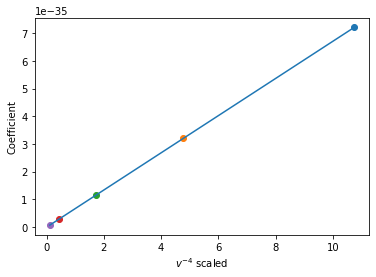

In [20]:
xs = [] #stores scaled 1/v^4
for velocity, k in zip(velocities, coeffs):
    #x axis needs to be scaled or else value is too small for fitting
    scaled_inv_velocity_4 = 1 / (velocity ** 4) * 1e29
    xs.append(scaled_inv_velocity_4)
    plt.scatter(scaled_inv_velocity_4, k)
popt = curve_fit(straight_line_fit,xs, coeffs)[0]
plt.plot(xs, straight_line_fit(np.array(xs), *popt))
plt.ylabel("Coefficient")
plt.xlabel(r"$v ^{-4} $ scaled")
plt.show()

## Crystal Lattice Scattering


In [21]:
#Rewrite solve function and rhs function for KDTree implementation
@jit(nopython=True)
def split_array(S):
    #Faster jitted splitting of array into alpha particle position and velocity components
    return np.array_split(S,2)

@jit(nopython=True, fastmath=True)
def rhs_fast_helper(alpha_position, alpha_velocity, element_charge, closest_positions):
    #Faster jitted helper function which returns the RHS
    force = coulomb_force(alpha_position, closest_positions, element_charge)
    acceleration = force.sum(axis = 0) / mass_of_alpha
    return np.hstack((alpha_velocity, acceleration))

def rhs_closest_positions(t, S, element_charge, atom_positions, tree):
    #rhs function that calculates force by finding nearest atoms (within a radius)
    #unable to jit as KDTree is incompatible with Numba so uses helper functions to maintain good speed
    force_radius = 1e-9
    num_closest = 4
    alpha_position, alpha_velocity = split_array(S)
    #find closest points within radius
    indices_closest_positions = tree.query_ball_point(alpha_position, force_radius)
    #find closest num_closest points if nothing is within radius or else solve_ivp will fail
    if len(indices_closest_positions) == 0:
        indices_closest_positions = tree.query(alpha_position, num_closest)[1]
    #returns the derivatives
    return rhs_fast_helper(alpha_position, alpha_velocity, element_charge, atom_positions[indices_closest_positions])

def runge_kutta_lattice(initial_pos, v0, element, atom_positions, method, tree, rtol=1e-4, atol=1e-6):
    #returns scattering angle by simulating a-particle trajectory through a lattice
    #uses KD tree to find closest points within radius of particle
    initial_v = np.array([v0, 0.0, 0.0])
    #cut-off time if it does not reach simulation boundary
    time_interval = sd * 2 / v0
    initial_S = np.hstack((initial_pos, initial_v))
    sol = solve_ivp(fun = lambda t,S: rhs_closest_positions(t, S, element.charge, atom_positions, tree), t_span = (0, time_interval), y0 = initial_S, events = reached_boundary, method = method, first_step = dt, rtol= rtol, atol=atol)
    if not sol.success:
        raise Exception("ODE solver failed to integrate")
    #number of time steps taken
    num_points = len(sol.t)
    #values of solution at each time step
    values = sol.y
    #retrieve final velocity
    final_v = values[:,num_points-1][3:6]
    theta = scattering_angle(initial_v, final_v)
    return theta

In [22]:
def random_position(radius):
    #initial position of alpha particle within a uniform circle of specified radius 
    radius = radius * math.sqrt(random.random())
    theta = 2 * math.pi * random.random()
    z = radius * math.cos(theta)
    y = radius * math.sin(theta)
    coordinates = np.array([-(x_max + starting_x), y, z])
    return coordinates

In [ ]:
"""
!!! DO NOT RUN MULTIPROCESSING ON JUPYTER NOTEBOOK
!!! Run in a python file
"""

if __name__ == "__main__":
    energy_of_alpha = 5.0
    v0 = energy_to_velocity(energy_of_alpha)  #starting velocity in x-axis
    element = gold
    atoms_thick = 10
    cross_section_atoms = 30 #number of atoms across y and z direction
    beam_radius = 1e-9
    num_alpha = int(1e5)
    NUM_PROCESSES = 8  #number of process to happen concurrently

    #Generate FCC lattice object
    atoms = FaceCenteredCubic(element.symbol, size=(atoms_thick, cross_section_atoms, cross_section_atoms))
    #2D array of atom positions
    atom_positions = atoms.get_positions()
    #to angstrom scale
    atom_positions *= 1e-10
    #centre to origin
    x_max,y_max,z_max = atom_positions.max(axis = 0)
    atom_positions[:,0] -= x_max / 2
    atom_positions[:,1] -= y_max / 2
    atom_positions[:,2] -= z_max / 2
    #reupdate the max atom positions
    x_max,y_max,z_max = atom_positions.max(axis = 0)
    #construct KD tree
    tree = cKDTree(atom_positions)

    list_of_starting_positions = [random_position(beam_radius) for _ in range(num_alpha)]
    #multiprocessing to get scattering angle given initial positions
    with Pool(NUM_PROCESSES) as p:
        thetas = p.map(partial(runge_kutta_lattice, tree=tree, v0=v0,element=element,atom_positions=atom_positions,method="LSODA",rtol=1e-4,atol=1e-6), list_of_starting_positions)
    thetas_in_deg = np.degrees(thetas)

    #saved to text file
    with open("scattering_data/____.txt", "a") as file:
        for theta in thetas_in_deg:
            file.write(f"{theta}\n")


In [ ]:
"""
!!! DO NOT RUN MULTIPROCESSING ON JUPYTER NOTEBOOK
!!! Run in a python file
"""

#INCLUDES ROTATING THE LATTICE 

def rotate_y(theta):
        return np.matrix([[ math.cos(theta), 0, math.sin(theta)],
                          [ 0              , 1, 0           ],
                          [-math.sin(theta), 0, math.cos(theta)]])
    
def rotate_z(theta):
    return np.matrix([[ math.cos(theta), -math.sin(theta), 0],
                        [ math.sin(theta),  math.cos(theta), 0],
                        [ 0              , 0               , 1]])

if __name__ == "__main__":
    energy_of_alpha = 5.0
    v0 = energy_to_velocity(energy_of_alpha)  #starting velocity in x-axis
    element = gold
    atoms_thick = 10
    cross_section_atoms = 30 #number of atoms across y and z direction
    beam_radius = 1e-9
    num_alpha = int(1e5)
    NUM_PROCESSES = 8  #number of process to happen concurrently

    #Generate FCC lattice object
    atoms = FaceCenteredCubic(element.symbol, size=(atoms_thick, cross_section_atoms, cross_section_atoms))
    #2D array of atom positions
    atom_positions = atoms.get_positions()
    #to angstrom scale
    atom_positions *= 1e-10
    #centre to origin
    x_max,y_max,z_max = atom_positions.max(axis = 0)
    atom_positions[:,0] -= x_max / 2
    atom_positions[:,1] -= y_max / 2
    atom_positions[:,2] -= z_max / 2

    #rotate the atom positions in y and z
    atom_positions = np.matmul(atom_positions, rotate_y(math.radians(15)))
    atom_positions = np.matmul(atom_positions, rotate_z(math.radians(10)))
    
    #turn back from matrix to numpy array after matrix multiplication
    atom_positions = np.squeeze(np.asarray(atom_positions))

    #reupdate the max atom positions
    x_max,y_max,z_max = atom_positions.max(axis = 0)
    #construct KD tree
    tree = cKDTree(atom_positions)

    list_of_starting_positions = [random_position(beam_radius) for _ in range(num_alpha)]
    #multiprocessing to get scattering angle given initial positions
    with Pool(NUM_PROCESSES) as p:
        thetas = p.map(partial(runge_kutta_lattice, tree=tree, v0=v0,element=element,atom_positions=atom_positions,method="LSODA",rtol=1e-4,atol=1e-6), list_of_starting_positions)
    thetas_in_deg = np.degrees(thetas)

    #saved to text file
    with open("scattering_data/____.txt", "a") as file:
        for theta in thetas_in_deg:
            file.write(f"{theta}\n")

## Data Analysis
Analyse how the no. of $\alpha$ particles scattered $N$ at angle $\theta$ varies for crystal lattice scattering

In [2]:
def file_to_arr(file, num_data=-1):
    #reads text file and translates into list of length num_data of scattering angles
    #if num_data is -1 choose all of the data points
    arr = []
    file_lines = file.readlines()
    #start from the 5th line
    if num_data == -1: file_lines = file_lines[4:]
    else: file_lines = file_lines[4:num_data+4]
    for line in file_lines:
        arr.append(float(line.strip("\n")))
    if num_data != -1 and num_data != len(arr):
        print("Insufficient data to match specified number")
    return arr

def file_to_counter(file, num_data=-1, binwidth=0.5):
    #returns a dictionary with keys of the scattering angle (bin centre) and values being no. of a particles landing at that angle
    #chooses num_data data points from text file (-1 means all data)
    #chooses bins of size binwidth
    thetas_arr = file_to_arr(file, num_data)
    counts, bins = np.histogram(thetas_arr,bins=np.arange(0.0, max(thetas_arr) + binwidth, binwidth))
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    counter = dict(zip(binscenters, counts))
    return counter

def plot_line_of_best_fit(xs, ys, ax, label="Fitted line", color="red"):
    #plots straight line onto ax and returns the gradient
    xs, ys = np.array(xs), np.array(ys)
    m, c = curve_fit(straight_line_fit, xs, ys)[0]
    ax.plot(xs, straight_line_fit(xs, m, c), color=color, label=label)
    return m


### Dependence on scattering angle
N($\theta$) $\propto$ $csc(\frac{\theta}{2})^4$

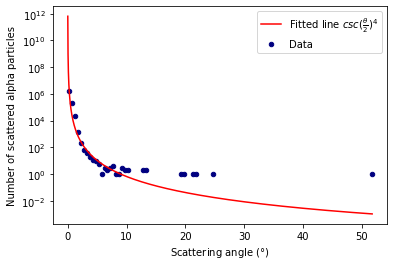

In [26]:
def plot_num_scattered_to_angle(file_name, num_data=-1, binwidth=0.5):
    with open(file_name) as file:
        #plot actual data as scatter plot
        counter = file_to_counter(file,num_data=num_data, binwidth=binwidth)
        binscenters = list(counter.keys())
        counts = list(counter.values())
        plt.scatter(binscenters, counts, color="navy", label="Data", s=20)

        #plot fitted line of k * csc(theta/2) ^ 4
        plotting_angles = np.arange(0.0, max(binscenters)+0.01,0.01) #generate enough x-values for plotting best fit
        popt, _ = curve_fit(cosec_half_4_fit, xdata=binscenters, ydata=counts) #get optimal params
        plt.plot(plotting_angles, cosec_half_4_fit(plotting_angles, *popt), color="red", label=r"Fitted line $csc(\frac{\theta}{2})^4$")
        plt.xlabel(r"Scattering angle $(\degree)$")
        plt.ylabel(r"Number of scattered alpha particles")
        plt.yscale("log")
        plt.legend()
        plt.show()

plot_num_scattered_to_angle('scattering_data/gold_10.txt', binwidth=0.5)   

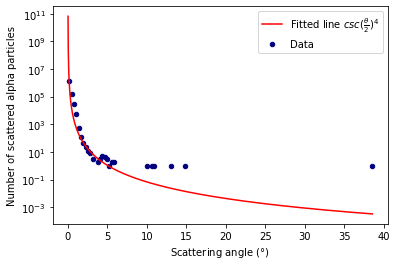

In [28]:
plot_num_scattered_to_angle('scattering_data/silver_10.txt', binwidth=0.3)   

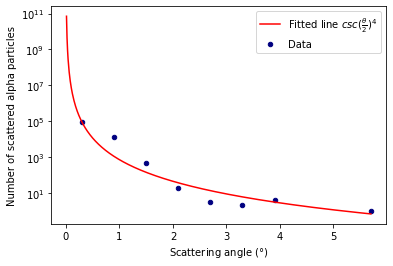

In [35]:
plot_num_scattered_to_angle('scattering_data/gold_30.txt', binwidth=0.6)   

Cosec4 gradient: 1.0784194249895904
Cosec1 gradient: 4.313677694915253


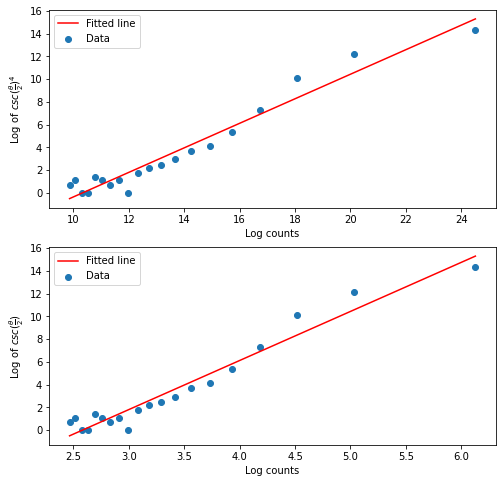

In [96]:
with open('scattering_data/gold_10.txt') as file:
    binwidth = 0.5
    max_angle = 10.0 #maximum angle for data used
    max_index = int(max_angle / binwidth) #will only use first max_index number of data points
    counter = file_to_counter(file, binwidth=binwidth)
    binscenters = list(counter.keys())
    counts = list(counter.values())

    counts = counts[:max_index]
    binscenters = binscenters[:max_index]
    fig, axes = plt.subplots(2, figsize=(8,8)) #axes[0] for cosec4, axes[1] for cosec1

    log_counts = np.log(counts)
    #replace -inf with 0
    log_counts = np.nan_to_num(log_counts, neginf=0)

    log_cosec_4 = np.log(cosec_half_4_fit(binscenters,1))
    log_cosec_1 = np.log(cosec_half_1_fit(binscenters,1))
    axes[0].scatter(log_cosec_4, log_counts, label="Data")    
    axes[1].scatter(log_cosec_1, log_counts, label="Data")

    cosec4_gradient = plot_line_of_best_fit(log_cosec_4, log_counts, axes[0])
    print(f"Cosec4 gradient: {cosec4_gradient}")
    cosec1_gradient = plot_line_of_best_fit(log_cosec_1, log_counts, axes[1])
    print(f"Cosec1 gradient: {cosec1_gradient}")

    axes[0].set_xlabel("Log counts")
    axes[1].set_xlabel("Log counts")
    axes[0].set_ylabel(r"Log of $csc(\frac{\theta}{2})^4$")
    axes[1].set_ylabel(r"Log of $csc(\frac{\theta}{2})$")
    axes[0].legend()
    axes[1].legend()
    plt.show()

### Dependence of atomic number of scattering nuclei
N($\theta$) $\propto$ $Q^2$

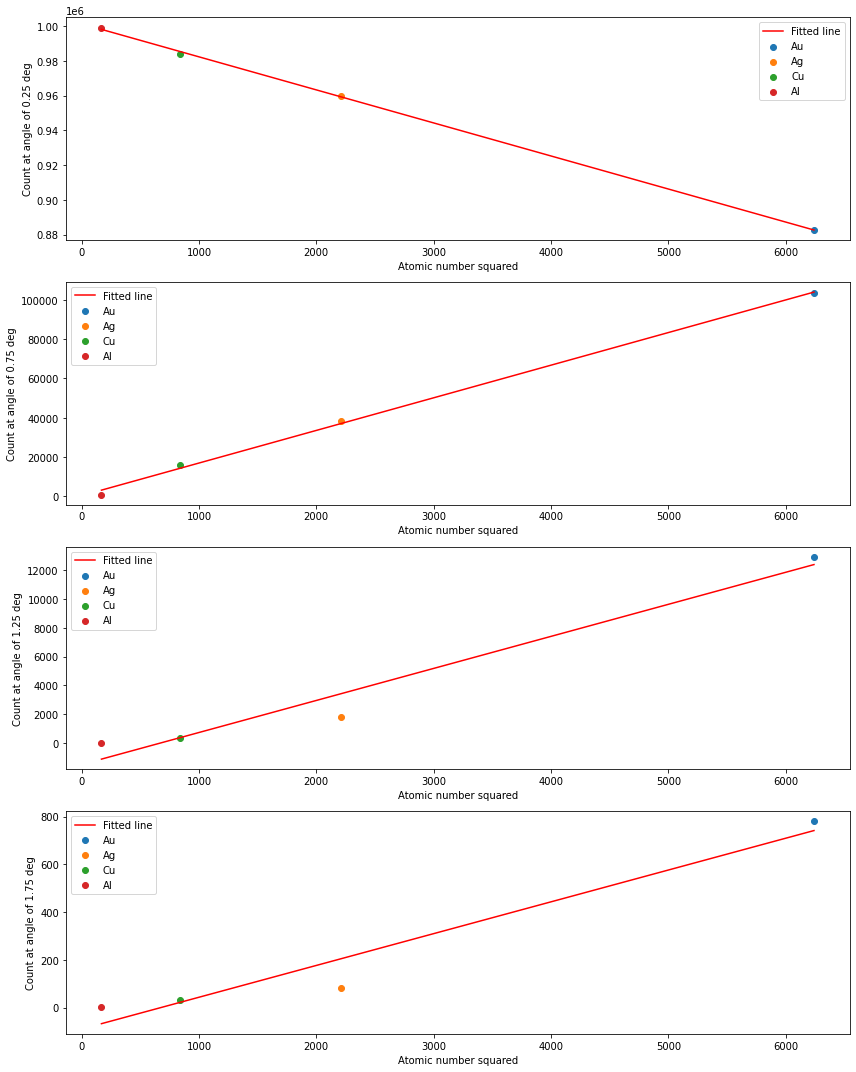

In [287]:
with open('scattering_data/gold_10.txt') as gold_file, open('scattering_data/silver_10.txt') as silver_file,  open('scattering_data/aluminium_10.txt') as aluminium_file,  open('scattering_data/copper_10.txt') as copper_file:
    files = [gold_file, silver_file, copper_file, aluminium_file]
    elements = [gold, silver, copper, aluminium]
    num_data = int(1e6)
    binsize = 0.5

    def plot_angle(angle, axes):
        #plot atomic number squared against number of scattered particles at parameter angle onto axis
        xs, ys = [], []
        for rounded_counter, element in zip(rounded_counters, elements):
            atomic_number_squared = element.atomic_number ** 2
            count = rounded_counter.get(angle, 0)
            axes.scatter(atomic_number_squared, count, label=element.symbol)
            xs.append(atomic_number_squared)
            ys.append(count)
        plot_line_of_best_fit(xs, ys, axes)

        axes.set_xlabel("Atomic number squared")
        axes.set_ylabel(f"Count at angle of {angle} deg")
        axes.legend()
    rounded_counters = list(map(partial(file_to_counter, num_data=num_data, binwidth=binsize), files))
    angles = np.arange(0.25,2.25,0.5)
    fig, ax = plt.subplots(len(angles), figsize=(12,15))
    for angle, axes in zip(angles, ax):
        plot_angle(angle, axes)
    plt.tight_layout()
    plt.show()


### Dependence on energy / velocity of alpha particle
N($\theta$) $\propto$ $\frac{1}{v^4}$

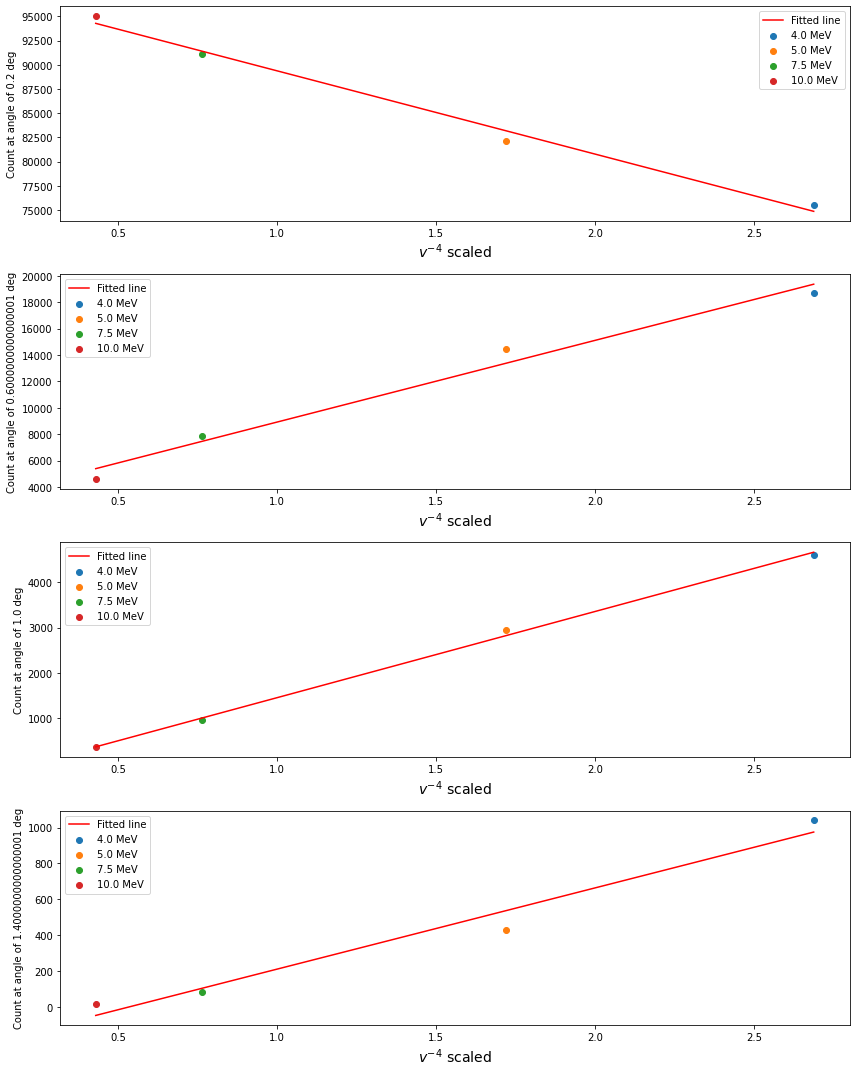

In [78]:
with open("scattering_data/gold_4_0_eV.txt") as energy_4_0_eV_file, open("scattering_data/gold_10.txt") as energy_5_0_eV_file, open("scattering_data/gold_7_5eV.txt") as energy_7_5_eV_file, open("scattering_data/gold_10_0_eV.txt") as energy_10_0_eV_file:
    files = [energy_4_0_eV_file, energy_5_0_eV_file, energy_7_5_eV_file, energy_10_0_eV_file]
    energies = [4.0, 5.0, 7.5, 10.0]
    speeds = np.array(list(map(energy_to_velocity, energies)))
    num_data = int(1e5)
    binsize = 0.5

    def plot_angle(angle, axes):
        #plot v^-4 against number of scattered particles at parameter angle onto axis
        xs, ys = [], []
        scaling_factor = 1e29 #1 / v ** 4 becomes too small for line fit so scaled up by factor
        for speed, rounded_counter, energy in zip(speeds, rounded_counters, energies):
            count = rounded_counter.get(angle, 0)
            inv_speed_4 = 1 / (speed ** 4) * scaling_factor
            xs.append(inv_speed_4)
            ys.append(count)
            axes.scatter(inv_speed_4, count, label=f"{energy} MeV")
        plot_line_of_best_fit(xs, ys, axes)
        axes.set_xlabel(r"$v ^{-4} $ scaled", fontsize=14)
        axes.set_ylabel(f"Count at angle of {angle} deg")
        axes.legend()
    rounded_counters = list(map(partial(file_to_counter, num_data = num_data, binwidth=binsize), files))
    angles = np.arange(0.25,2.25,0.5)
    fig, ax = plt.subplots(len(angles), figsize=(12,15))
    for angle, axes in zip(angles, ax):
        plot_angle(angle, axes)
    plt.tight_layout()
    plt.show()

### Dependence on thickness of the foil
N($\theta$) $\propto$ $t$

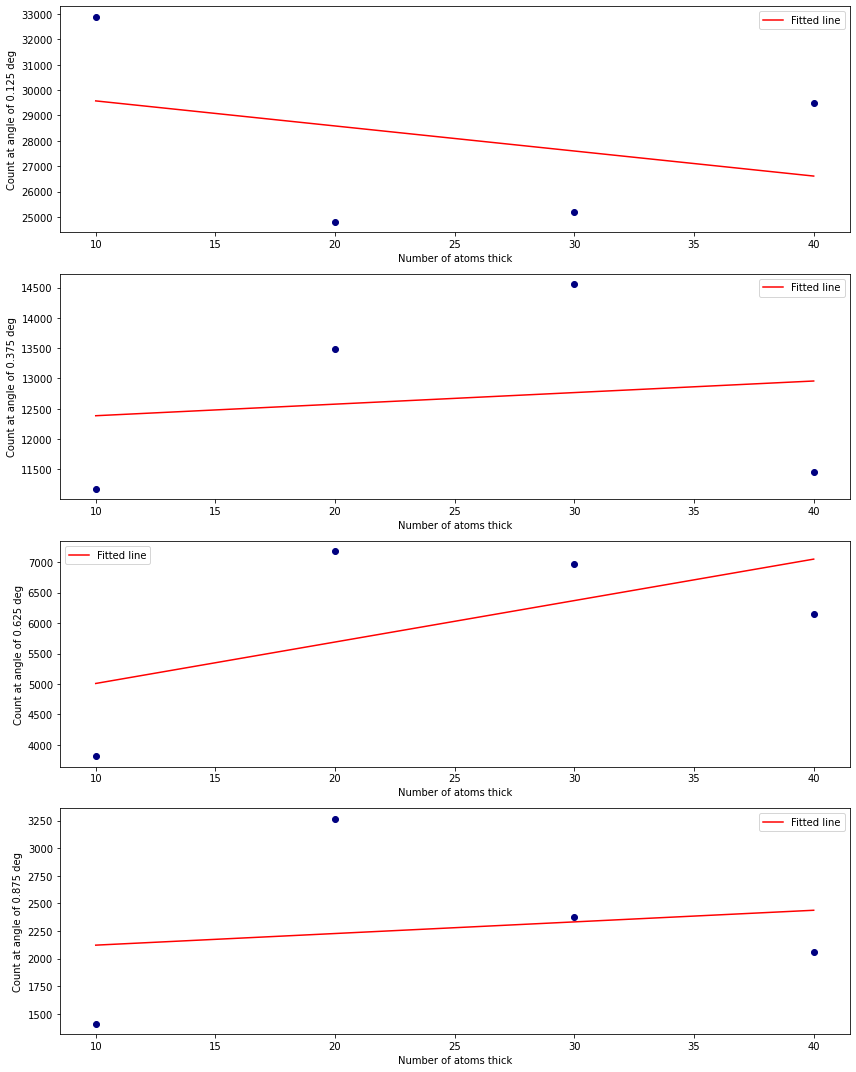

In [24]:
#NON ROTATED
with open('scattering_data/gold_10.txt') as gold_10_file,  open('scattering_data/gold_15.txt') as gold_15_file,  open('scattering_data/gold_20.txt') as gold_20_file, open('scattering_data/gold_30.txt') as gold_30_file, open('scattering_data/gold_40.txt') as gold_40_file:
    files = [gold_10_file, gold_20_file, gold_30_file, gold_40_file]
    thicknesses = [10, 20, 30, 40]
    num_data = int(5e4)
    binsize = 0.25


    def plot_angle(angle, axes):
        #plot atomic number squared against number of scattered particles at parameter angle onto axis
        xs, ys = [], []
        for rounded_counter, thickness in zip(rounded_counters, thicknesses):
            count = rounded_counter.get(angle, 0)
            axes.scatter(thickness, count, color="navy")
            xs.append(thickness)
            ys.append(count)
        plot_line_of_best_fit(xs, ys, axes)

        axes.set_xlabel("Number of atoms thick")
        axes.set_ylabel(f"Count at angle of {angle} deg")
        axes.legend()

    rounded_counters = list(map(partial(file_to_counter, num_data=num_data, binwidth=binsize), files))

    angles = np.arange(0.125,1,0.25)
    # angles = list(rounded_counters[0].keys())[:4]
    fig, ax = plt.subplots(len(angles), figsize=(12,15))
    for angle, axes in zip(angles, ax):
        plot_angle(angle, axes)
    plt.tight_layout()
    plt.show()

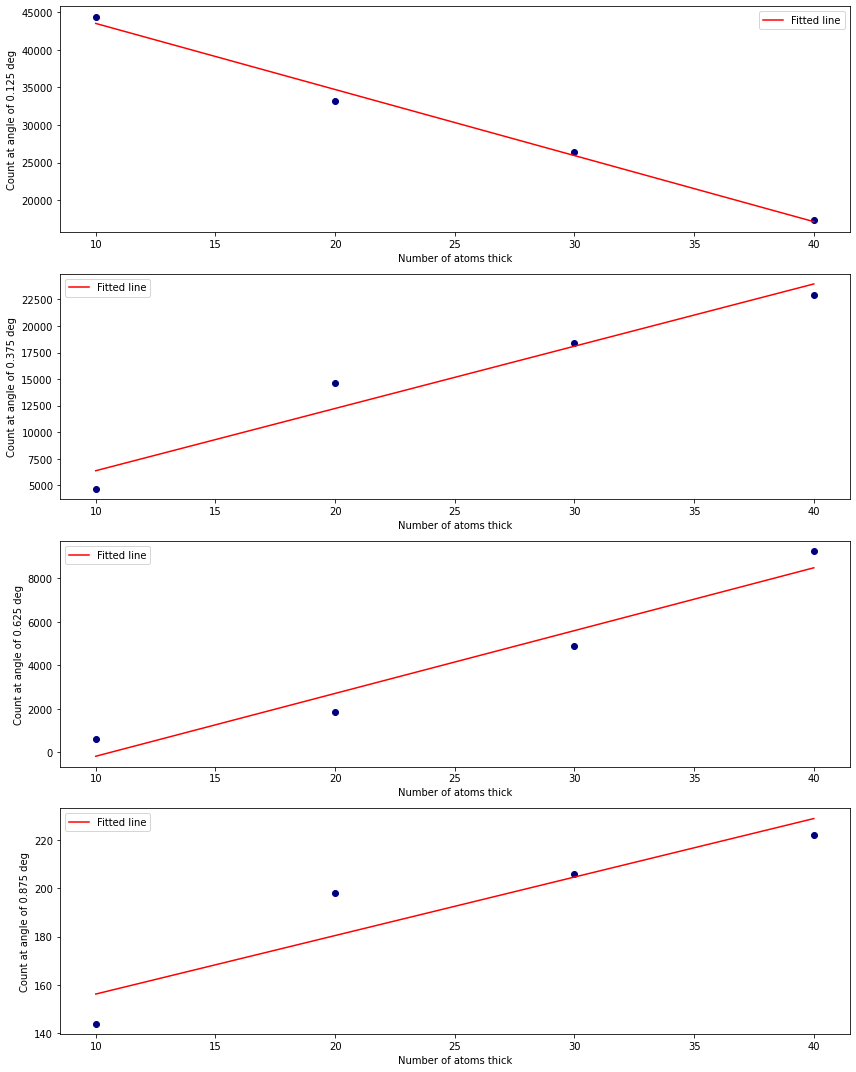

In [23]:
#ROTATED
with open('scattering_data/gold_10_rotated.txt') as gold_10_file, open('scattering_data/gold_20_rotated.txt') as gold_20_file,open('scattering_data/gold_30_rotated.txt') as gold_30_file,  open('scattering_data/gold_40_rotated.txt') as gold_40_file:
    files = [gold_10_file, gold_20_file, gold_30_file, gold_40_file]
    thicknesses = [10, 20, 30, 40]
    num_data = int(5e4)
    binsize = 0.25


    def plot_angle(angle, axes):
        #plot atomic number squared against number of scattered particles at parameter angle onto axis
        xs, ys = [], []
        for rounded_counter, thickness in zip(rounded_counters, thicknesses):
            count = rounded_counter.get(angle, 0)
            axes.scatter(thickness, count, color="navy")
            xs.append(thickness)
            ys.append(count)
        plot_line_of_best_fit(xs, ys, axes)

        axes.set_xlabel("Number of atoms thick")
        axes.set_ylabel(f"Count at angle of {angle} deg")
        axes.legend()


    rounded_counters = list(map(partial(file_to_counter, num_data=num_data, binwidth=binsize), files))

    angles = np.arange(0.125,1,0.25)
    fig, ax = plt.subplots(len(angles), figsize=(12,15))
    for angle, axes in zip(angles, ax):
        plot_angle(angle, axes)
    plt.tight_layout()
    plt.show()


### Dependence on number of incident alpha particles
N($\theta$) $\propto$ $N_{0}$

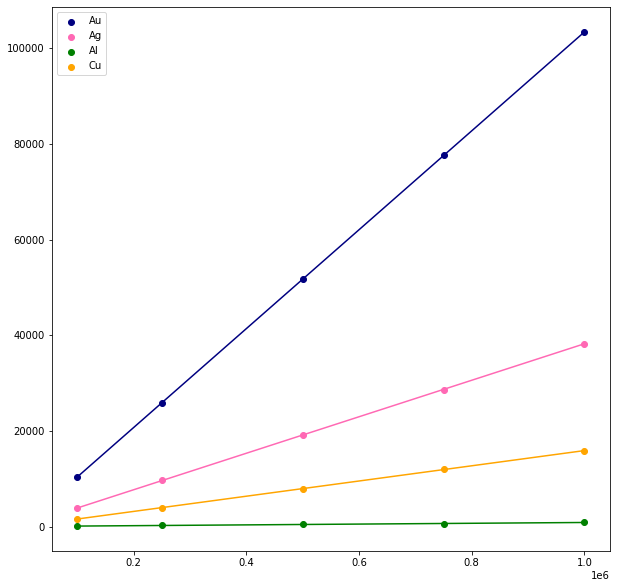

In [22]:
all_file_names = ['scattering_data/gold_10.txt', 'scattering_data/silver_10.txt', 'scattering_data/aluminium_10.txt', 'scattering_data/copper_10.txt']
corresponding_elements = [gold, silver, aluminium, copper]
colors = ["navy", "hotpink", "green", "orange"]
binwidth = 0.5
angle = 0.75 #specified angle
num_datas = [1e5, 2.5e5, 5e5, 7.5e5, 1e6] #how many alpha particles to fire / number of data to choose from
fig, ax = plt.subplots(figsize=(10,10))
for file_name, element, color in zip(all_file_names, corresponding_elements, colors):
    counts = [] #store number of scattered particles at specific angle
    for num_data in map(int, num_datas):
        with open(file_name) as file:
            counter = file_to_counter(file, num_data=num_data, binwidth=binwidth)
            counts.append(counter[angle])
    ax.scatter(num_datas, counts, color=color,label=element.symbol)
    plot_line_of_best_fit(num_datas, counts, ax, label=None, color=color)
plt.legend()
plt.show()